# Segmentación de vehículos a motor

## Introducción

En este cuaderno vamos a llevar a cabo la resolución de un problema de segmentación semántica para imágenes de vehículos a motor mediante la librería fastai y el dataset COCO.

Esto consiste en, dada una imagen, clasificar cada uno de sus píxeles como un determinado tipo de vehículo o cualquier cosa diferente, es decir, fondo. Para ello es necesario que todos los datos de entrenamiento estén etiquetados punto a punto, cosa que no sucedía con el dataset utilizado para clasificación pero que sí con el dataset COCO.

En primer lugar explicaremos cómo se realiza todo el preprocesado de los datos, desde que se descarga el dataset hasta que creamos los cargadores necesarios para entrenar nuestro modelo. A continuación, realizaremos entrenamientos con diferentes parámetros y tamaño de las imágenes de entrada para finalmente, realizar la evaluación en datos de test de la mejor configuración encontrada.

Debemos tener en cuenta que la segmentación semántica de imágenes es una tarea computacionalmente costosa. La cantidad de pruebas y experimentos realizados está limitada por los tiempos de ejecución y los límites de uso de Colab.

## Preprocesado de los datos

Como se ha dicho, vamos a emplear el dataset COCO, concretamente en su versión 2014. Éste está formado aproximadamente por unas 83000 imágenes para el conjunto de entrenamiento y unas 41000 para el conjunto de validación, que nostros utilizaremos como test. Todas ellas etiquetadas píxel a píxel para 80 clases diferentes, no solo correspondientes a vehículos, sino a elementos de otro tipo.

Además, dispone de una API para manejar los datos en base a sus anotaciones, es decir, su etiquetado. El dataset viene dividido en tres partes:

La información del dataset nos viene dividida en tres partes:
* **_train_**: con las imágenes de entrenamiento.
* **_val_**: con las imágenes que emplearemos como test.
* **_annotations_**: que contiene las etiquetas de las imágenes de _train_ y _val_.

Vamos a descargar en primer lugar el dataset junto con API, que al no estar incluida en Colab, deberemos instalar a mano. En total tenemos unos 20GB de datos a descargar y descomprimir, lo que puede llevar de 15 a 30 minutos dependiendo del estado de los servidores.

In [ ]:
#Ignoramos la salidad de la celda
%%capture

# Descargamos los datos de entrenamiento, validación y anotaciones de COCO
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q train2014.zip
%rm train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip -q val2014.zip
%rm val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q annotations_trainval2014.zip
%rm annotations_trainval2014.zip

In [ ]:
#Ignoramos la salida de la celda
%%capture

# Descargamos la API de COCO y la instalamos, migrando primero los archivos python2 a python3
!pip install 2to3
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi
!2to3 . -w
%cd PythonAPI
!python3 setup.py install
%cd /content

In [ ]:
#Ignoramos la salida de la celda
%%capture

# Importamos los manejadores de COCO
from pycocotools import coco

# Importamos la parte necesaria de fastai
from fastai.vision.all import *

# Y las demás librerías que usaremos
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os

Una vez descargadas las imágenes junto a sus anotaciones e instalada la API necesaria para el manejo del dataset, el siguiente paso será seleccionar aquellas (imágenes) que contengan en su etiquetado al menos un punto clasificado como una de las categorías correspondientes a los vehículos a motor terrestres deseados (car, motorbike, bus, truck, y train). Además, aprovecharemos para hacer un recuento del número de imágenes de cada clase, con el objetivo de ver si hay sobre representación de alguna de ellas y en ese caso, proceder de una forma adecuada.

Para ello utilizaremos las siguientes funciones y métodos de la API de COCO:
* **_COCO(archivo)_**: constructor de la clase principal que carga los archivos *json* de anotaciones y prepara las estructuras necesarias.
* **_COCO.getCatIds(catNms)_**: devuelve los ids numéricos de las categorías especificadas en el parámetro *catNms*.
* **_COCO.getImgIds(catIds)_**: devuelve los ids numéricos de las imágenes en las que aparecen a la vez todas las categorías indicadas mediante su id en *catIds*. Por tanto, debemos ejecutar el método individualmente para cada categoría y posteriormente eliminar elementos repetidos.
* **_COCO.loadImgs(imgIds)_**: obtiene una lista de diccionarios, cada uno con la ruta, las dimensiones y algunos otros elementos más de cada imagen.


In [ ]:
#Ignoramos la salidad de la celda
%%capture

# Marcamos las categorias que nos interesan
CATEGORY_NAMES=['car', 'motorcycle', 'bus', 'truck', 'train']

# Ficheros de anotaciones para la segmentación de las imágenes
ANNOTATION_FILE_TRAIN = '/content/annotations/instances_train2014.json'
ANNOTATION_FILE_VAL = '/content/annotations/instances_val2014.json'

# Cargamos los archivos de anotaciones y preparamos las estructuras de datos
coco_train = coco.COCO(ANNOTATION_FILE_TRAIN)
coco_val = coco.COCO(ANNOTATION_FILE_VAL)

# Cargamos los ids correspondientes a las categorías especificadas
cat_ids_train = coco_train.getCatIds(catNms=CATEGORY_NAMES)
cat_ids_val = coco_val.getCatIds(catNms=CATEGORY_NAMES)

# Listas para guardar los ids de las imágenes
img_ids_train = []
img_ids_val= []

# Listas para guardar el número de imágenes en las que aparece cada categoría
dist_cat_train = []
dist_cat_val = []

# Obtenemos los ids y la distribución de las imagenes para cada categoría
for cat in cat_ids_train:
  img_ids_train = img_ids_train + coco_train.getImgIds(catIds=cat)
  dist_cat_train.append(len(coco_train.getImgIds(catIds=cat)))

for cat in cat_ids_val:
  img_ids_val = img_ids_val + coco_val.getImgIds(catIds=cat)
  dist_cat_val.append(len(coco_val.getImgIds(catIds=cat)))

# Eliminamos elementos repetidos
img_ids_train = list(set(img_ids_train))
img_ids_val = list(set(img_ids_val))

# Cargamos las imagenes con dichos ids, el nombre se encuentra en el campo 'file_name'
img_dict_train = coco_train.loadImgs(img_ids_train)
img_dict_val = coco_val.loadImgs(img_ids_val)

In [ ]:
print(f'Número de imágenes de entrenamiento: {len(img_dict_train)}')
print(f'Número de imágenes de validación: {len(img_dict_val)}')

Número de imágenes de entrenamiento: 14831
Número de imágenes de validación: 7319


Una vez obtenidas las listas de imágenes a utilizar para *train* y *val*, a cuyo nombre podemos acceder mediante el campo *file_name* de cada uno de los diccionarios obtenidos, eliminamos de los directorios todas aquellas imágenes que no corresponden a los vehículos a motor necesarios para la segmentación.

In [ ]:
# Obtenemos las listas con los nombres de las imágenes a utilizar
train_images_names = [d['file_name'] for d in img_dict_train]
val_images_names = [d['file_name'] for d in img_dict_val]

# Borramos aquellas imagenes innecesarias de los conjuntos de entrenamiento y validación
del_img_train = set(os.listdir("/content/train2014")) - set(train_images_names)
for file_name in del_img_train:
  file_name = "/content/train2014/" + file_name
  if os.path.exists(file_name):
    os.remove(file_name)

del_img_val = set(os.listdir("/content/val2014")) - set(val_images_names)
for file_name in del_img_val:
  file_name = "/content/val2014/" + file_name
  if os.path.exists(file_name):
    os.remove(file_name)

print(f'Número de imágenes de entrenamiento: {len(os.listdir("/content/train2014"))}')
print(f'Número de imágenes de validación: {len(os.listdir("/content/val2014"))}')

Número de imágenes de entrenamiento: 14831
Número de imágenes de validación: 7319


Ahora, a partir de las anotaciones debemos obtener la máscara correspondiente a cada una de las imágenes. Una máscara es un array bidimensional en el que cada punto corresponde a la etiqueta asignada a éste.

Un primer error fue el codificar éstas en imágenes en formato *.jpg*, al igual que las imágenes. El problema es que este formato está basado en un tipo de compresión con pérdida, haciendo que los valores almacenados puedan variar ligeramente; por ello, almacenamos las máscaras en archivos *.png*, cada uno con el mismo nombre que su respectiva imagen. Las colocaremos en las carpetas *mask_train_2014* y *mask_val_2014*, dependiendo de si son imágenes de entrenamiento o test.

Vamos a explicar el resto de los métodos de la API de COCO que se han utilizado para crear las máscaras:
* **_COCO.getAnnIds(imgIds, catIds)_**: obtiene los ids de las anotaciones para las categorías *catIds* de las imágenes *imgIds*.
* **_COCO.loadAnns(annIds)_**: carga las anotaciones para los ids *annIds*. Cada anotación es un diccionario con campos como el id de la clase a la que pertenece la anotación.
* **_COCO.annToMask(ann)_**: pasa una determinada anotación *ann* a su máscara (array) correspondiente indicando con 1 la posición de los objetos correpondientes a su clase (0 para el resto). Debemos tener en cuenta que normalmente una imagen tendrá varias anotaciones.

Para crear la máscara correspondiente a cada imagen vamos superponiendo las mácaras correspondientes a cada una de sus anotaciones, cada una multiplicada por el índice en el que se encuentra la clase a la que corresponde la anotación en la lista de los ids de las categorías, más 1 (ya que el 0 corresponde al fondo). De esta forma, la máscara resultante puede tener valores desde 0 hasta *n*, siendo *n* el número de categorías posibles.

In [ ]:
# Borramos el directorio para las máscaras (en caso de exixtir) y lo creamos de nuevo vacío
!rm -r mask_train_2014
!mkdir mask_train_2014

# Para cada imagen de entrenamiento (accedemos mediante su diccionario)
for dic in img_dict_train:
  # Añadimos los directorios correspondientes al nombre de la imagen
  file_path = '/content/mask_train_2014/' + dic['file_name'].split(sep='.')[0] + '.png'

  # Obtenemos los ids de las anotaciones de la imagen para las categorias con las que trabajamos
  ann_ids = coco_train.getAnnIds(imgIds=dic['id'], catIds=cat_ids_train)

  # Cargamos las anotaciones de la imagen
  anns = coco_train.loadAnns(ann_ids)

  # Convertimos las anotaciones en una máscara, cada máscara individual se multiplica por el id de su categoría
  mask = coco_train.annToMask(anns[0])
  mask = mask * (cat_ids_train.index(anns[0]['category_id']) + 1)
  for i in range(len(anns)):
    mask_aux = coco_train.annToMask(anns[i]) * (cat_ids_train.index(anns[i]['category_id']) + 1)
    mask_nzero = mask_aux != 0
    mask[mask_nzero] = mask_aux[mask_nzero]

  # Ponemos la imagen correspondiente a la máscara en escala de grises
  mask = Image.fromarray(mask)

  # Guardamos la imagen en la carpeta mask_train_2014
  mask.save(file_path)

rm: cannot remove 'mask_train_2014': No such file or directory


In [ ]:
# Borramos el directorio para las máscaras (en caso de exixtir) y lo creamos de nuevo vacío
!rm -r mask_val_2014
!mkdir mask_val_2014

# Para cada imagen de entrenamiento (accedemos mediante su diccionario)
for dic in img_dict_val:
  # Añadimos los directorios correspondientes al nombre de la imagen
  file_path = '/content/mask_val_2014/' + dic['file_name'].split(sep='.')[0] + '.png'

  # Obtenemos los ids de las anotaciones de la imagen para las categorias con las que trabajamos
  ann_ids = coco_val.getAnnIds(imgIds=dic['id'], catIds=cat_ids_val)

  # Cargamos las anotaciones de la imagen
  anns = coco_val.loadAnns(ann_ids)

  # Convertimos las anotaciones en una máscara, cada máscara individual se multiplica por el id de su categoría
  mask = coco_val.annToMask(anns[0]) * (cat_ids_val.index(anns[0]['category_id']) + 1)
  for i in range(len(anns)):
    mask_aux = coco_val.annToMask(anns[i]) * (cat_ids_val.index(anns[i]['category_id']) + 1)
    mask_nzero = mask_aux != 0
    mask[mask_nzero] = mask_aux[mask_nzero]

  # Ponemos la imagen correspondiente a la máscara en escala de grises
  mask = Image.fromarray(mask, mode='L')

  # Guardamos la imagen en la carpeta mask_train_2014
  mask.save(file_path)

rm: cannot remove 'mask_val_2014': No such file or directory


Una vez realizado el preprocesado de los datos, podemos pasar a la creación de los dataloaders para el entrenamiento de los modelos. Sin embargo, en primer lugar vamos a comentar la distribución de las categorías en las imágenes.

In [ ]:
# Mostramos el número de imágenes de cada conjunto y la distribución para cada clase
print(f'Número de imágenes de entrenamiento: {len(img_dict_train)}')
print(f'Número de imágenes de validación: {len(img_dict_val)}\n')
print(f'Distribucion de clases en entrenamiento: {dist_cat_train}')
print(f'Distribucion de clases en validación: {dist_cat_val}')

Número de imágenes de entrenamiento: 14831
Número de imágenes de validación: 7319

Distribucion de clases en entrenamiento: [8606, 2442, 2791, 2464, 4321]
Distribucion de clases en validación: [4180, 1219, 1350, 1281, 2056]


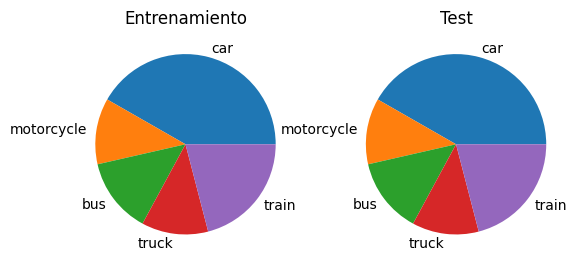

In [ ]:
# Mostramos las distribuciones de cada conjunto gráficamente
plt.subplot(1,2,1)
plt.pie(dist_cat_train, labels=CATEGORY_NAMES)
plt.title("Entrenamiento")

plt.subplot(1,2,2)
plt.pie(dist_cat_train, labels=CATEGORY_NAMES)
plt.title("Test")

plt.show()

Como podemos ver, hay una clara predominancia de imágenes que contienen coches frente al resto de tipos; y cierta mayor cantidad de trenes frente a las clases moto, bus y camión, que son minoritarias. En un principio ignoraremos este problema, sin embargo, posteriormente analizaremos una estrategia para intentar resolverlo y comentaremos los resultados obtenidos.

## Data loaders

Lo siguiente que haremos será crear un objeto de la clase _SegmentationDataLoaders_, el cual se encargará de definir cómo se preprocesan y estructuran los datos de entrenamiento en el problema de segmentación, de forma similar a los _DataLoaders_ en clasificación. Para crear el objeto, usaremos la función _from_label_func_, que consta de los siguientes parámetros:

* __*path*__: ruta de donde obtener las imágenes, en nuestro caso, será la carpeta _train2014_.
* __*bs*__: tamaño de minibatches a emplear, utilizaremos 8 en todos los casos. Al ser un tamaño relativamente pequeño, se está introduciendo un cierto nivel de ruido estocástico en el gradiente, lo que puede tener un efecto de regularización positivo.
* __*fnames*__: nombres de los archivos a cargar.
* __*valid_pct*__: porcentaje de ejemplos a reservar para validación. Elegiremos el 20%, pues es un valor común que nos permite no prescindir de muchas imágenes, a la vez de darnos una buena seguridad estadística.
* __*label_func*__: función para obtener la ruta a la máscara correspondiente a cada imagen.
* __*codes*__: nombres de cada categoría a clasificar. Estos serán los nombres de nuestros vehículos, más el fondo.
* __*item_tfms*__: indica las transformaciones que se realizan sobre cada imagen de forma individual para preprocesarlas.
* __*batch_tfms*__: indica las transformaciones que se realizan sobre todas las imágenes en conjunto.

Inicialmente, vamos a definir que el tamaño de las imágenes del _DataLoader_ sea de 256x256. Este tamaño determinará en gran medida cuánto tardará cada época del entrenamiento en ejecutarse. Por contra, si elegimos un tamaño de imagen demasiado pequeño, la imagen perderá resolución y será más difícil para el modelo aprender de los clústers pequeños.

Por otro lado, en las transformaciones a nivel de _batch_ usaremos aumento de datos. Esto nos permitirá obtener más ejemplos de entrenamiento para nuestra red modificando ligeramente los que ya tenemos, lo cual ayudará en buena medida a la generalización del modelo. Concretamente, cuadruplicaremos los datos aplicando volteo horizontal, rotaciones de hasta 10 grados, zoom de hasta el 10%, y cambios suaves en la iluminación. Después, normalizaremos los valores con las estadísticas de ImageNet, ya que esto resultará en un entreno más rápido de nuestros modelos.

In [ ]:
# Obtenemos las rutas completas de los archivos de train y val
train_images_paths = ['/content/train2014/' + name for name in train_images_names]
val_images_paths = ['/content/val2014/' + name for name in val_images_names]

# Dada la ruta a una imagen devuelve la ruta a su máscara
def get_labels(ruta):
  nombre = os.path.basename(ruta).split(sep='.')[0] + '.png'

  if 'train' in ruta:
    return f'/content/mask_train_2014/{nombre}'

  else:
    return f'/content/mask_val_2014/{nombre}'

In [ ]:
#Ignoramos la salida de la celda
%%capture

# Por defecto, las imágenes se reescalan con interpolación bicúbica y las máscaras con el vecino más cercano
dls_train_256 = SegmentationDataLoaders.from_label_func(
    '/content/train2014', bs=8, fnames = train_images_paths, valid_pct=0.2,
    label_func = get_labels, codes = ['background'] + CATEGORY_NAMES,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms = [*aug_transforms(mult=4, p_affine=0.5, do_flip=True, flip_vert=False,
                                  max_rotate=10, min_zoom=1.0, max_zoom=1.1,
                                  max_warp=0,  # Desactivamos las deformaciones
                                  p_lighting=0.5, max_lighting=0.1),
                  Normalize.from_stats(*imagenet_stats)]
)

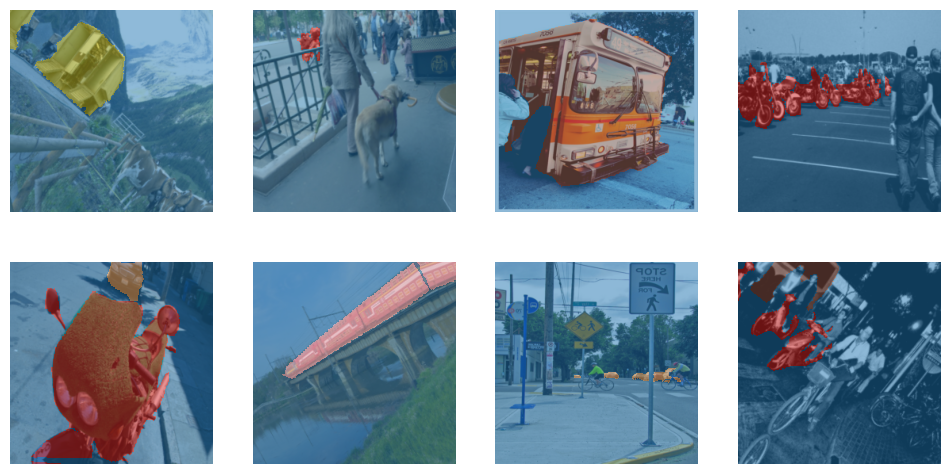

In [ ]:
# Mostramos un batch del conjunto de entrenamiento
dls_train_256.show_batch()

## UNet

A la hora de segmentar imágenes, debemos tener en cuenta que la salida de la red para cada una de éstas será una matriz tridimensional del mismo ancho y alto que la imagen original, y de un canal por cada categoría, que representa la probabilidad para ese punto de pertenecer a ella. Está claro que no podemos utilizar tal cual una arquitectura clásica de red convolucional como podría ser *resnet* o *VGG*, que van reduciendo progresivamente los mapas de activación. Necesitamos que, aunque éstos se reduzcan en una primera fase debido a cuestiones de eficiencia, posteriormente vuelvan a aumentarse hasta llegar al tamaño original.

Es ahí donde entran las redes denominadas *encoder-decorder*, como U-Net, modelo que vamos a utilizar para este problema y cuya estructura podemos ver en la imagen inferior. Este tipo de arquitecturas se dividen principalmente en dos partes: un _encoder_, que va reduciendo progresivamente el tamaño de las imágenes y aumentando el número de canales, capturando así características a diferentes niveles de abstracción; y el _decoder_, el cual vuelve a aumentar el tamaño de las imágenes y reducir el número de canales de forma simétrica a como lo hizo el _encoder_ para poder producir la salida final. La idea de esta red es combinar características de bajo nivel con el _encoder_, como detalles e información espacial, y de alto nivel, las cuales obtenemos a través del _decoder_.

Esto, tal cual se ha comentado tiene un enorme problema, durante la reducción de los mapas de activación realizada por el encoder se pierde prácticamente toda la información contextual sobre la localización de los elementos que forman la imagen. La forma de solventar este problema puede variar significativamente el función del modelo utilizado. El el caso de U-Net se añaden los denominados *skip connections* (flechas grises de la imagen inferior), que combinan los mapas de activación originales en cada nivel con los obtenidos durante el upsampling aprovechándose de que la estructura de la red es simétrica.



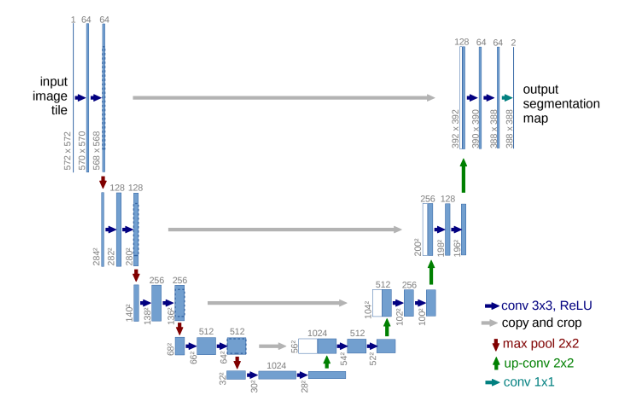

Realmente, aunque en la teoría se explique U-Net con estructuras como la anterior, que sólo utiliza capas convolucionales y de pooling, en la práctica, el encoder suele ser un modelo de red convolucional bastante más potente y conocido como puede ser ResNet34 (se pueden utilizar otros). De esta forma se realiza una extracción de características muy efectiva además de permitir importar importar parámetros ya entrenados para esa red realizando así *transfer learning*. A esta red que forma el encoder se le suele denominar backbone, en nuestro caso, será ResNet34.

## Métricas

Cuando hablamos de problemas de clasificación, una de las métricas más utilizadas es la accuracy, que mide la proporción de aciertos respecto al total en una clasificación. En su versión base, ésta tiene el problema de que puede no ser del todo representativa en problemas con clases desbalaceadas al poder clasificar la mayoría de ejemplos como la clase mayoritaria y aun así reflejar buenos resultados.

El principal problema aquí (y en los problemas de segmentación en general), aparte de que tenemos distinto número de imágenes en las que aparece cada vehículo y que en cada imagen la proporción de puntos correspondientes a ese vehículo es diferente, es que normalmente la mayor parte de la superficie de nuestras imágenes, en gran parte de los casos va a correponderse a fondo. Un modelo que clasificase todos los píxeles como fondo podría obtener buenos resultados, por lo que este tipo de métricas pueden no ser las más informativas en problemas de segmentación.

Nosotros vamos a utilizar dos métricas que evitan este problema, **Dice** aplicada para multiclase (**DiceMulti**) y una versión de accuracy (**foreground_acc**) implementada por *fastai* que sólo se calcula para aquellos puntos que no corresponden a fondo (su etiqueta es distinta a 0) en la etiqueta verdadera. Veamos más a fondo en qué consiste el coeficiente de Dice:

Éste mide la similitud entre la máscara verdadera y la predicha ignorando el fondo, es decir, la superposición o concordancia entre regiones segmentadas. Su fórmula es:

$$Dice=\frac{2*|X\cap Y|}{|X|+|Y|}$$

Donde:
* $∣X\cap Y∣$ es el número de píxeles (ignorando el fondo) que pertenecen tanto a la máscara predicha como a la verdadera.
* $∣X∣$ es el número total de píxeles (ignorando el fondo) en la máscara predicha.
* $∣Y∣$ es el número total de píxeles (ignorando el fondo) en la máscara verdadera.

Un valor de 1 significa una superposición perfecta y un valor de 0 una superposición nula entre regiones segmentadas (ignorando el fondo). Nótese que esta fórmula se aplica a segmentación binaria, en segmentación multiclase se calcula independientemente sobre cada categoría y posteriormente se computa la media.

## Entrenamiento

### Entrenamiento 256

Como se ha dicho, en primer lugar vamos a entrenar nuestro modelo (U-Net con Resnet34 como backbone y entropía cruzada como función de pérdida) con imágenes de dimensión 256x256. Debemos saber que tanto el ancho como el alto de las imágenes originales de COCO está comprendido en los 400 y 600 píxeles aproximadamente, por lo que al reducirlas podríamos estar perdiendo información valiosa para la segmentación.

El problema es que una sola época con imágenes 512x512 puede tardar unos 40 minutos, un entrenamiento de unas pocas épocas sería inviable en colab. Posteriormente veremos una solución a este problema mediante progressive resizing.

Vamos a utilizar la red Resnet34 que utiliza nuestra U-Net como encoder con pesos ya preentrenados en IMAGENET, lo que hará que los resultados desde el pricipio sean mejores a los que obtendríamos al inicializar los pesos de la red de otra forma.

In [ ]:
#Ignoramos la salida de la celda
%%capture

# Creamos el learner para unet preentrenado con resnet34 como backbone
learn_256 = unet_learner(dls_train_256, resnet34, normalize=True, pretrained=True,
                        loss_func=CrossEntropyLossFlat(axis=1), metrics=[DiceMulti, foreground_acc])

In [ ]:
learn_256.summary()

/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


DynamicUnet (Input shape: 8 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

Si observamos la estructura de la red podemos diferenciar fácilmente tres zonas: el encoder, formado por capas convolucionales con función de activación ReLU y capas de max pooling, donde la dimensionalidad de los mapas de activación se va reduciendo; una zona intermedia formada por capas convolucionales, donde la dimensión de los mapas de activación se mantiene pero se juega con el número de canales; y finalmente el decoder, donde por medio de la concatenación de las salidas de las capas convolucionales del encoder con las salidas upsamleadas de sus propias capas convolucionales, se llega a la segmentación final.

Fijémonos cómo todas las capas convolucionales del encoder están congeladas al haber sido importados pesos preentrenados para éstas. No ocurre los mismo con las capas de batch normalization, cuyos pesos deben ajustarse desde un principio para adecuarse al problema concreto. Vamos a hacer un fine tuning a nuestra red, entrenando durante tres épocas las capas descongeladas, y durante otras tres épocas la red al completo. Utilizaremos la función lr_find para estimar el larning rate óptimo en cada caso.

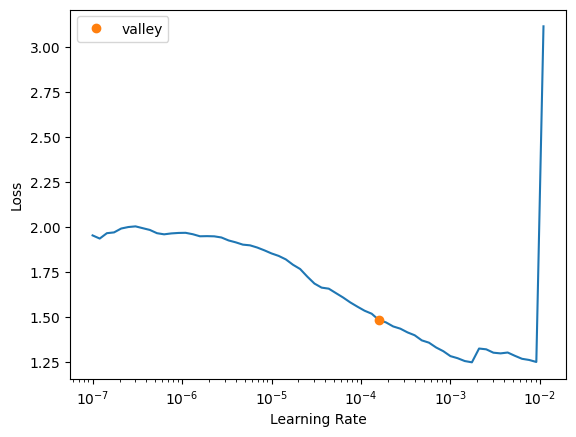

In [ ]:
# Buscamos el learning rate óptimo
lr = learn_256.lr_find()

In [ ]:
# Realizamos el entrenamiento de la parte intermedia y el decoder
learn_256.fit_one_cycle(3, lr_max=lr[0])

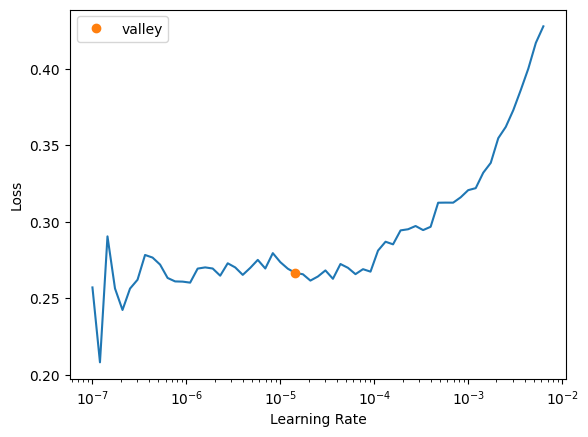

In [ ]:
# Descongelamos la red
learn_256.unfreeze()

# Buscamos el learning rate óptimo
lr = learn_256.lr_find()

# Entrenamos la red al completo
learn_256.fit_one_cycle(3, lr_max=lr[0])

Como podemos ver, gracias al tranfer learning, los resultados desde un principio son relativamente buenos y con únicamente 3 épocas entrenando la parte intermedia y el decoder de la red (y las capas de batch normalization), llegamos a un 0.77 en el coeficiente de Dice y a un 0.7 para la accuracy en todo aquello que no sea fondo.

Una vez descongelamos la red, podemos ver que en la primera época, la función de pérdida en entrenamiento aumenta un poco su valor. Sin embargo, en las dos siguientes, éste vuelve a bajar, consiguiendo resultados un poco mejores que los que obtuvimos con el decoder congelado, aproximademente un 1.5% más.

Si nos fijamos en las funiones de pérdida mostradas en las tablas podemos ver como a excepción de la última época, en todo momento, aunque ambas disminuyan, el valor en validación se mantiene más bajo que el valor en entrenamiento, lo que nos quiere decir que probablemente éste (el conjunto de validación) sea más sencillo.

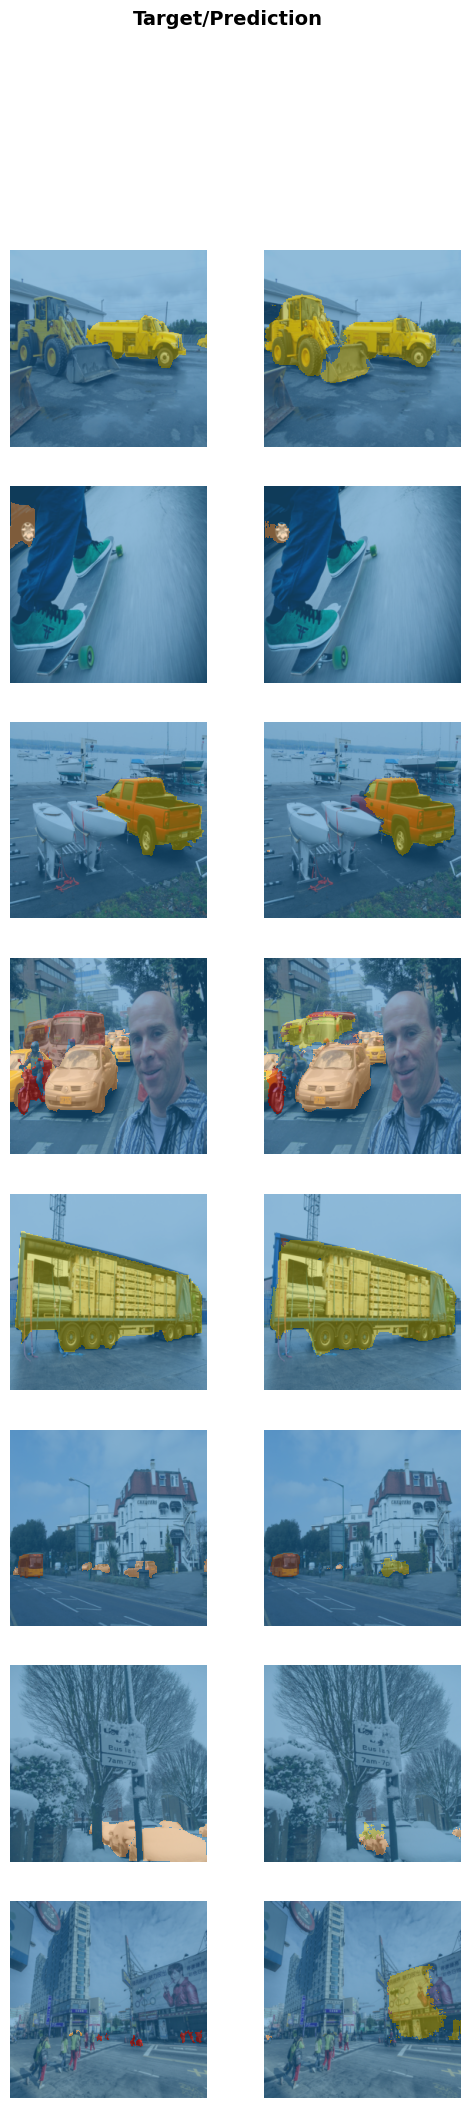

In [ ]:
# Mostramos algunas de las predicciones
learn_256.show_results()

En las imágenes superiores podemos ver para algunas de las imágenes su segmentación real y la obtenida por nuestro modelo. Podemos ver que aunque en algunos casos no es capaz de ajustarse por completo a toda la superficie de los objetos, o de delimitar con toda precisión los bordes; la segmentación se hace relativamente bien.

### Entrenamiento 128

El principal problema que tiene entrenar el modelo con imágenes de 256x256 es que el tiempo de ejecución de cada época (unos 11 minutos), aunque quizá en un caso real con recursos de procesamiento adecuados no sería un problema; aquí es demasiado. Vamos a probar a entrenar el mismo modelo, esta vez con imágenes de la mitad de tamaño (128x128), durante el mismo número de épocas para ver si con un tiempo de ejecución menor, podemos obtener resultados similares.

In [ ]:
# Por defecto, las imágenes se reescalan con interpolación bicúbica y las máscaras con el vecino más cercano
dls_train_128 = SegmentationDataLoaders.from_label_func(
    '/content/train2014', bs=8, fnames = train_images_paths, valid_pct=0.2,
    label_func = get_labels, codes = ['background'] + CATEGORY_NAMES,
    item_tfms=[Resize(128, method='squish')],
    batch_tfms = [*aug_transforms(mult=4, p_affine=0.5, do_flip=True, flip_vert=False,
                                  max_rotate=10, min_zoom=1.0, max_zoom=1.1,
                                  max_warp=0,  # Desactivamos las deformaciones
                                  p_lighting=0.5, max_lighting=0.1),
                  Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
#Ignoramos la salidad de la celda
%%capture

# Creamos el learner para unet preentrenado con resnet34 como backbone
learn_128 = unet_learner(dls_train_128, resnet34, normalize=True, pretrained=True,
                        loss_func=CrossEntropyLossFlat(axis=1), metrics=[DiceMulti, foreground_acc])

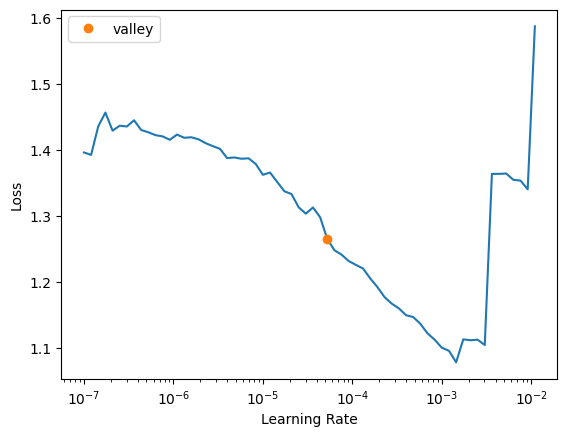

In [ ]:
# Buscamos el learning rate óptimo
lr = learn_128.lr_find()

In [ ]:
# Realizamos el entrenamiento de la parte intermedia y el decoder
learn_128.fit_one_cycle(3, lr_max=lr[0])

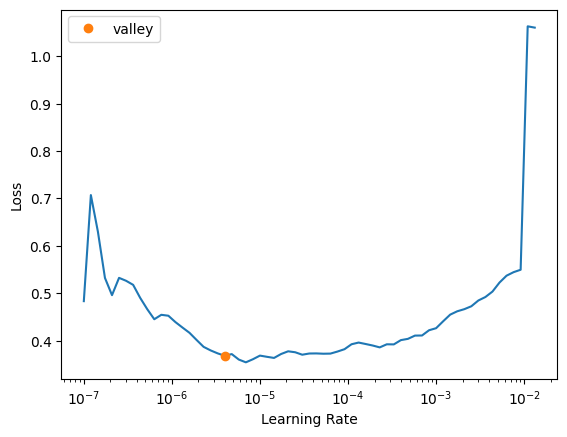

In [ ]:
# Descongelamos la red
learn_128.unfreeze()

# Buscamos el learning rate óptimo
lr = learn_128.lr_find()

# Entrenamos la red al completo
learn_128.fit_one_cycle(3, lr_max=lr[0])

En este caso en entrenamiento es correcto, en todo momento ambas funciones de pérdida van descendiendo, estando la de validación de nuevo por debajo de entrenamiento. Sin embargo, los resultados obtenidos en este caso son significativamente peores, aproximadamente un 0.12 menos para dice y casi un 0.2 menos para foreground accuracy. Sin embargo, el tiempo de ejecución se ha reducido a la mitad (de 11 a unos 5 minutos) aproximadamente.

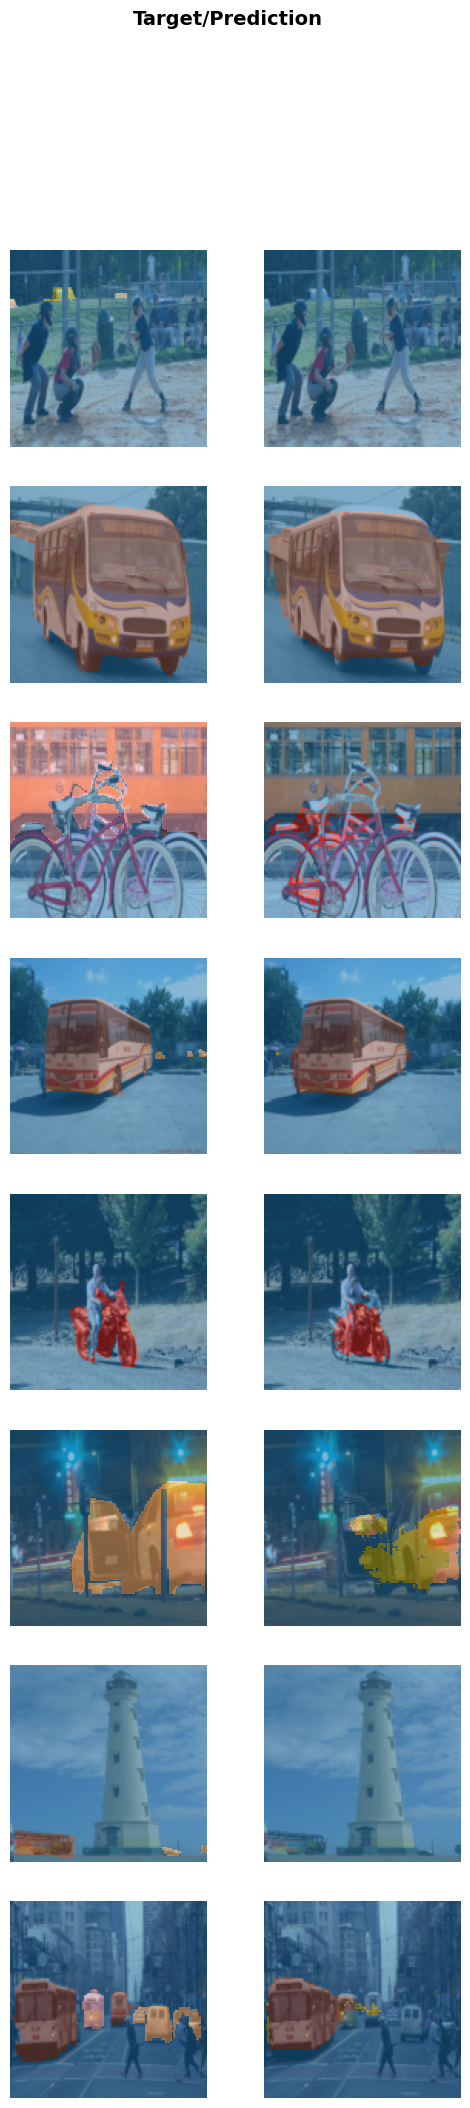

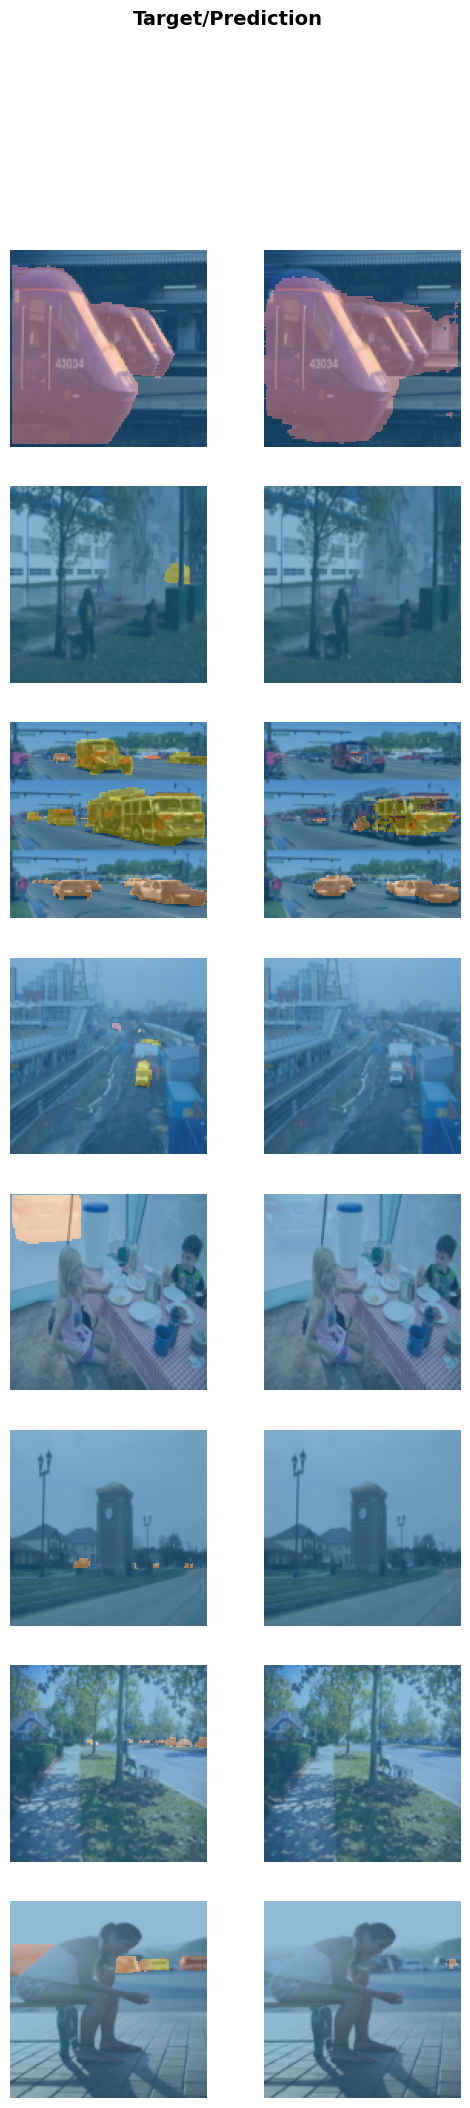

In [ ]:
# Mostramos algunas de las predicciones
learn_128.show_results()
learn_128.show_results()

En las imágenes inferiores podemos ver cómo en este caso, a nuestro modelo le resulta mucho más difícil segmentar correctamente los detalles finos de las imágenes. Esto se debe a que al reducir su tamaño, también estamos perdiendo parte importante de la información. Quizá esto pueda no resultar un problema demasiado significativo a la hora de segmentar objetos cuya superficie en la imagen sea grande, sin embargo, sí lo es al segmentar objetos que ocupen una superficie menor en la imagen.

### Entrenamiento 128 con pesos

Hasta ahora, a la hora de calcular la función de pérdida, se he dado la misma importancia a la clasificación de cada uno de los puntos de cada imagen. Cómo hemos visto durante la etapa de procesamiento de los datos, cada clase aparece en un número distinto de imágenes. Además, la superficie que ocupa cada clase en cada una de las imágenes puede ser diferente.

Es este apartado vamos a utilizar un modelo en el que vamos a ponderar la contribución de cada una de las clases a la función de pérdida mediante unos determinados pesos. Vamos a calcular esos pesos de una forma muy aproximada en base únicamente al número de imágenes en las que aparece cada clase.

Para ello tomamos la mediana de la lista en la que hemos almacenado previamente las apariciones de cada clase en las imágenes. Dividimos la mediana entre cada valor para hacer que la contribución de una clase sea inversamente proporcional al número de veces que ésta aparece. El peso para el fondo lo calculamos como el menor peso obtenido en el paso anterior dividido por el número de clases a segmentar.

In [ ]:
# Mediana del número de imágenes para cada clase
median = np.median(np.array(dist_cat_train))

# Pesos inversamente proporcionales según la mediana
weight = np.array([median/w for w in dist_cat_train])

# Añadimos peso para el fondo
weight = np.concatenate((np.array([np.min(weight)/len(weight)]), weight))

# Pasamos a tensor el array de pesos
weight = torch.tensor(weight.astype(np.float32)).cuda()

print(weight)

tensor([0.0649, 0.3243, 1.1429, 1.0000, 1.1327, 0.6459], device='cuda:0')


In [ ]:
# Creamos el learner para unet preentrenado con resnet34 como backbone
learn_128_w = unet_learner(dls_train_128, resnet34, normalize=True, pretrained=True,
                          loss_func=CrossEntropyLossFlat(axis=1, weight=weight), metrics=[DiceMulti, foreground_acc])

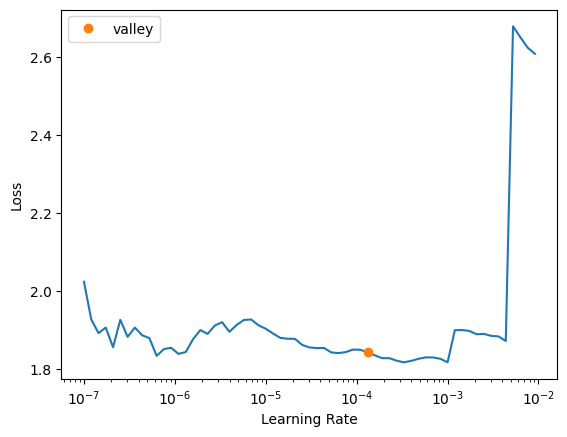

In [ ]:
# Buscamos el learning rate óptimo
lr = learn_128_w.lr_find()

In [ ]:
# Realizamos el entrenamiento de la parte intermedia y el decoder
learn_128_w.fit_one_cycle(3, lr_max=lr[0])

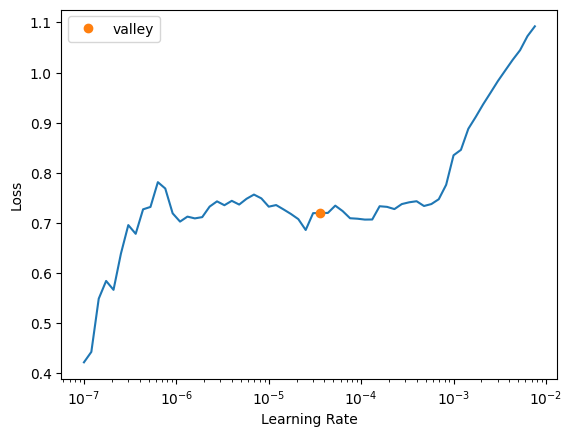

In [ ]:
# Descongelamos la red
learn_128_w.unfreeze()

# Buscamos el learning rate óptimo
lr = learn_128_w.lr_find()

# Entrenamos la red al completo
learn_128_w.fit_one_cycle(3, lr_max=lr[0])

Si comparamos los resultados con la segmentación realizada para imágenes del mismo tamaño (128x128) sin pesos, podemos apreciar algo curioso, aunque el resultado obtenido para Dice en validación en 0.05 peor, el resultado de foreground accuracy es casi 0.2 mejor; ayudándonos de las imágenes inferiores vamos a intentar razonar qué puede significar esto.

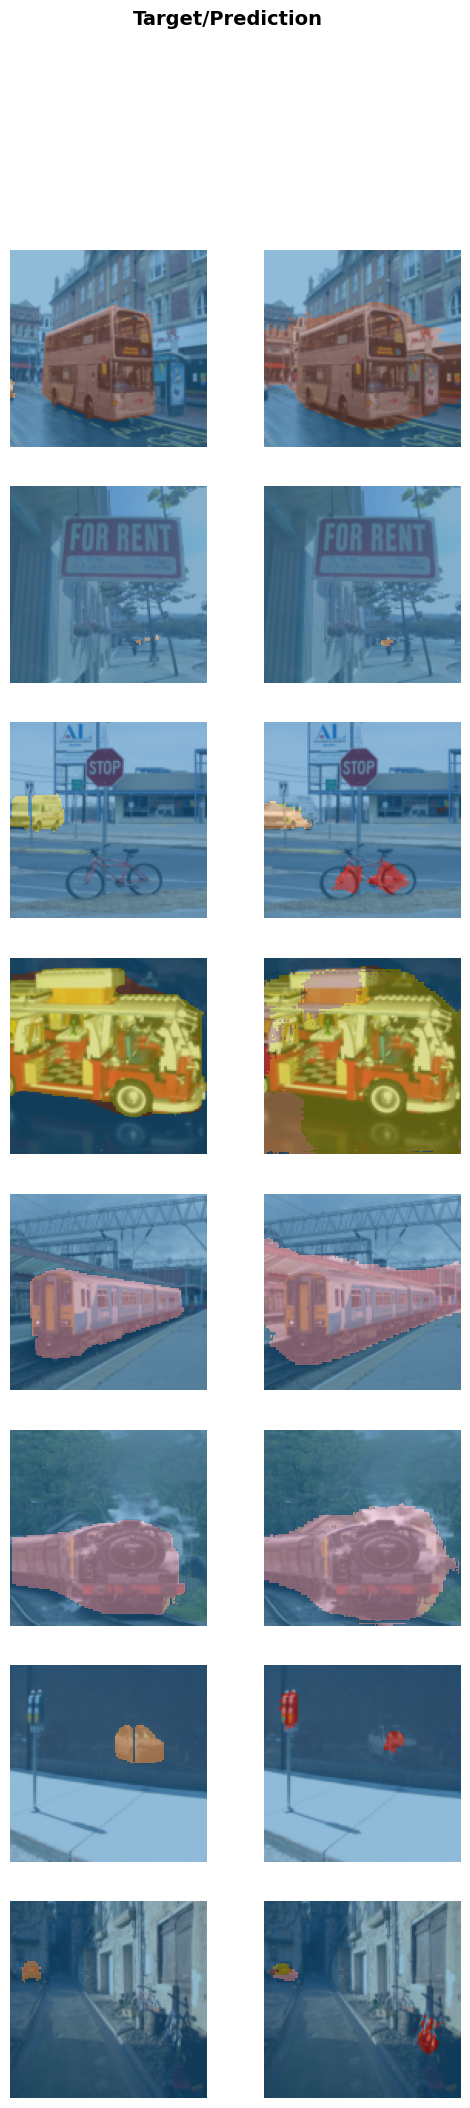

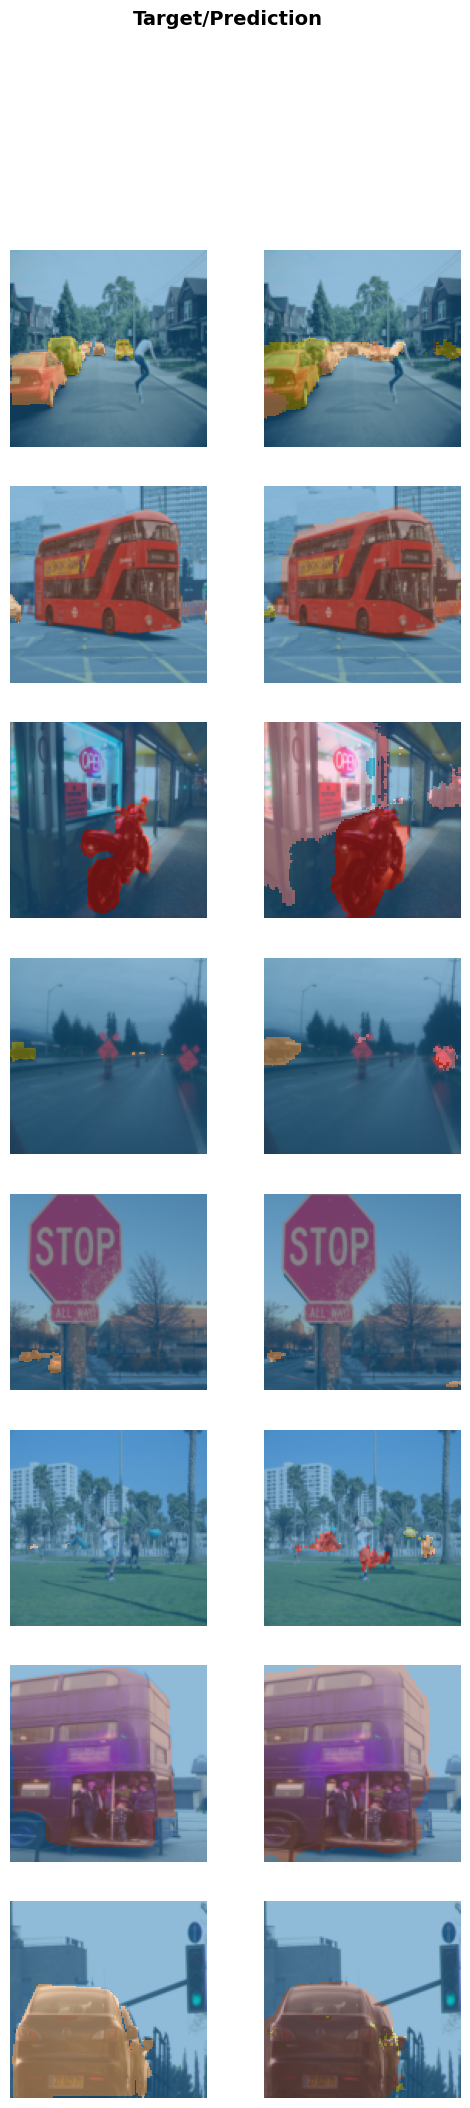

In [ ]:
# Mostramos algunas de las predicciones
learn_128_w.show_results()
learn_128_w.show_results()

Lo primero que vemos rápidamente es cómo al ser bastante menor la pérdida al equivocarse clasificando puntos correspondientes al fondo, las 'manchas' que segmentan a cada uno de los objetos normalmente son más grandes que la segmentación real de estos (véase por ejemplo la quinta imagen correspondiente a un tren de color azul, blanco y naranja). Antes ocurría justamente lo contrario, los modelos se quedaban cortos a la hora de segmentar cada uno de los objetos, sin llegar a abarcar normalmente toda su área.

Es esto precisamente lo que hace que la accuracy en todo aquello que no sea fondo sea mucho mejor, porque se segmenta como una determinada clase más área de la cuenta (entiende como mejor pasarse que quedarse corto). Sin embargo, ésto no es algo positivo a la hora de calcular Dice ya que la correspondencia entre las etiquetas y las predicciones no es demasiado precisa al ser el área de las predicciones mucho mayor.

El hecho de decir que unos resultados sean mejor que otros (a la hora de comparar los modelos con y sin pesos) es muy relativo y va a depender mucho de la métrica por la que decidamos guiarnos a la hora de evaluar nuestro problema. Quizá con unos pesos algo más precisos podríamos haber obtenido mejores resultados en ambas métricas.

### Progressive resizing

Hasta ahora hemos visto que normalmente, cuanto maś grande es el tamaño de la imagen a segmentar, mayor es la información que ésta contiene y por tanto mejores son las predicciones. El principal problema es el la forma en la que el tiempo de ejecución escala respecto al tamaño de las imágenes que utilizamos.

Es por esto por lo que surge el progressive resizing (lo hace para problemas de clasificación, pero la utilidad es exactamente la misma en segmentación), que va entrenando un mismo modelo cada vez con imágenes más grandes. De esta forma, se obtienen las características generales de las imágenes más reducidas en tiempos mucho menores y se van añadendo detecciones a nivel de detalle más fino a medida que el tamaño de las imágenes va aumentando (haciéndolo también los tiempos de ejecución). Esto además tiene otra importante ventaja, una regularización implícita al trabajar en versiones suavizadas y generales (debido a la redimensión) de las imágenes originales.

Vamos a ir aumentando progresivamente el tamaño de las imágenes en 64x64, 128x128, 256x256 y finalmente 512x512, reduciendo progresivamente el número de épocas utilizadas en cada entrenamiento. Partiendo de un modelo preentrenado, la idea inicial es hacer que cada vez que se cambiaban las dimensiones de la entrada, realizar un fine tuning, entrenando un determinado número de épocas con el encoder congelado y otro determinado número de épocas con la red al completo.

In [ ]:
# Por defecto, las imágenes se reescalan con interpolación bicúbica y las máscaras con el vecino más cercano
dls_train_64 = SegmentationDataLoaders.from_label_func(
    '/content/train2014', bs=8, fnames = train_images_paths, valid_pct=0.2,
    label_func = get_labels, codes = ['background'] + CATEGORY_NAMES,
    item_tfms=[Resize(64, method='squish')],
    batch_tfms = [*aug_transforms(mult=4, p_affine=0.5, do_flip=True, flip_vert=False,
                                  max_rotate=10, min_zoom=1.0, max_zoom=1.1,
                                  max_warp=0,  # Desactivamos las deformaciones
                                  p_lighting=0.5, max_lighting=0.1),
                  Normalize.from_stats(*imagenet_stats)]
)

# Creamos el learner para unet preentrenado con resnet34 como backbone
learn_64 = unet_learner(dls_train_64, resnet34, normalize=True, pretrained=True,
                        loss_func=CrossEntropyLossFlat(axis=1), metrics=[DiceMulti, foreground_acc])

In [ ]:
# Entrenamos la red congelada 3 épocas y la red completa 5
learn_64.fine_tune(epochs=5, freeze_epochs=3)

Como era de esperar, al entrenar con imágenes de 64x64, el resultado alcanzado está bastante lejos de los que obteníamos en ejecuciones anteriores con imágenes más grandes. Sin embargo, podemos ver cómo el tiempo de ejecución es  aproximadamente un minuto por época menor que en imágenes de 128x128, lo cual no es demasiada diferencia teniendo en cuenta que los resultados son bastante peores.

Se puede ver cómo en la última época incluso se ha sobreajustado un poco el modelo, al no haber ejecutado más épocas, no podemos saber si ésta hubiese sido la tendencia general. Vamos a continuar con el proceso cambiando el dataloader por el de imágenes de 128x128.

In [ ]:
# Cambiamos el nombre del learner (la referencia sigue siendo la misma)
learn_128_p = learn_64

# Cambiamos el data loaders por el de imágenes de mayor tamaño
learn_128_p.dls = dls_train_128

In [ ]:
# Entrenamos la red congelada 1 época y la red completa 3
learn_128_p.fine_tune(epochs=3, freeze_epochs=1)

Lo primero que podemos ver es cómo en la época en la que la red se ha entrenado congelada, los resultados han empeorado enormemente. Quizá no sea necesario entrenar la red de esta forma ya que, aunque los datos de entrada sean diferentes, en el fondo son las mismas imágenes con más detalle.

Una vez que entrenamos con la red al completo podemos ver cómo los resultados mejoran respecto a los obtenidos con imágenes de 64x64. Sigamos con el proceso, ahora entrenando el mismo modelo con imágenes 128x128.

In [ ]:
# Cambiamos el nombre del learner (la referencia sigue siendo la misma)
learn_256_p = learn_128_p

# Cambiamos el data loaders por el de imágenes de mayor tamaño
learn_256_p.dls = dls_train_256

In [ ]:
# Entrenamos la red congelada una época y la red entera otra
learn_256_p.fine_tune(epochs=1, freeze_epochs=1)

De nuevo, vemos como sucede algo similar, al entrenar la red congelada, los resultados empeoran normalmente. Sin embargo, posteriormente estos vuelven a recuperarse llegando a alcanzar un valor algo mejor.

Finalmente, vamos a entrenar la red completa con imágenes 512x512 durante una sola época ya que cada una dura aproximadamente unos 40 minutos.

In [ ]:
# Por defecto, las imágenes se reescalan con interpolación bicúbica y las máscaras con el vecino más cercano
dls_train_512 = SegmentationDataLoaders.from_label_func(
    '/content/train2014', bs=8, fnames = train_images_paths, valid_pct=0.2,
    label_func = get_labels, codes = ['background'] + CATEGORY_NAMES,
    item_tfms=[Resize(512, method='squish')],
    batch_tfms = [*aug_transforms(mult=4, p_affine=0.5, do_flip=True, flip_vert=False,
                                  max_rotate=10, min_zoom=1.0, max_zoom=1.1,
                                  max_warp=0,  # Desactivamos las deformaciones
                                  p_lighting=0.5, max_lighting=0.1),
                  Normalize.from_stats(*imagenet_stats)]
)

# Cambiamos el nombre del learner (la referencia sigue siendo la misma)
learn_512_p = learn_256_p

# Cambiamos el data loaders por el de imágenes de mayor tamaño
learn_512_p.dls = dls_train_512

In [ ]:
# Entrenamos la red al completo durante una sola época
learn_512_p.fine_tune(epochs=1, freeze_epochs=0)

Como podemos ver, los resultados no han mejorado prácticamente nada, lo que nos quiere decir que, o bien eran necesarias más épocas para alcanzar mejores resultados, o que no es necesario utilizar imágenes tan grandes ya que las de 256x256 contienen una información similar a la hora de realizar la segmentación.


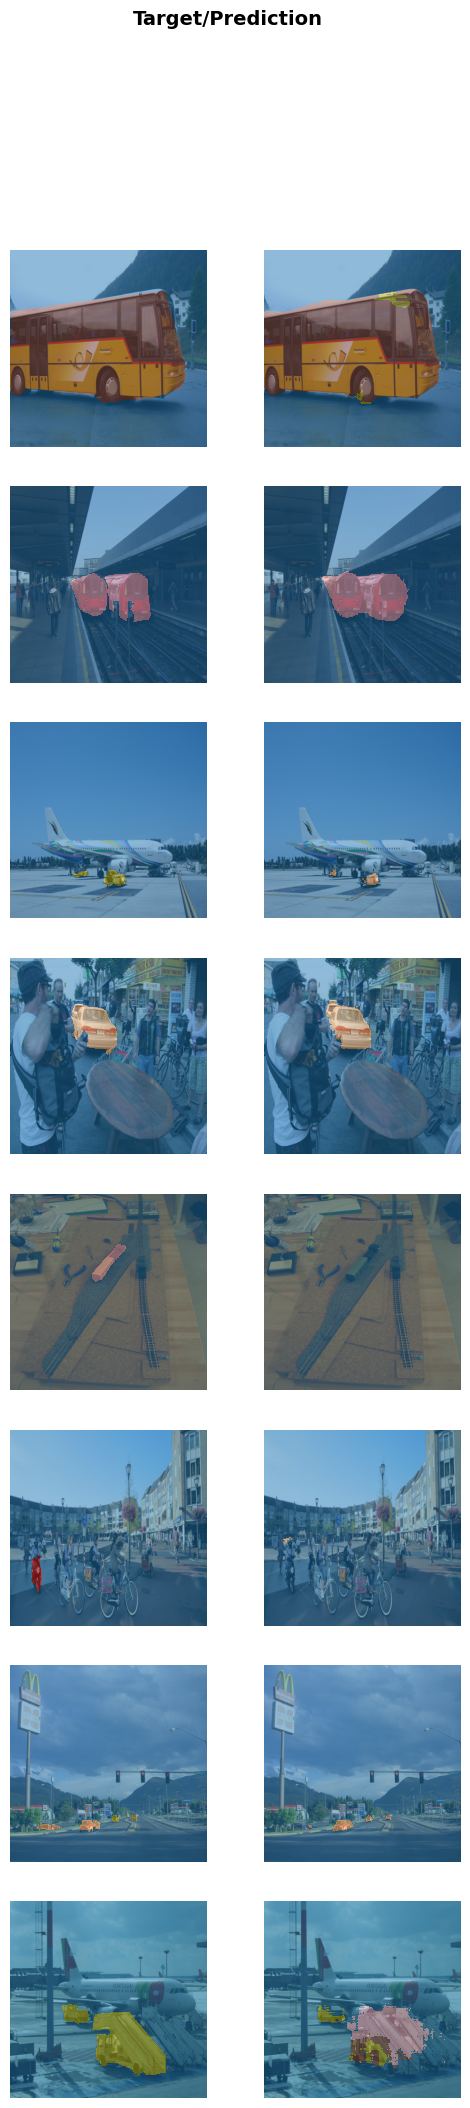

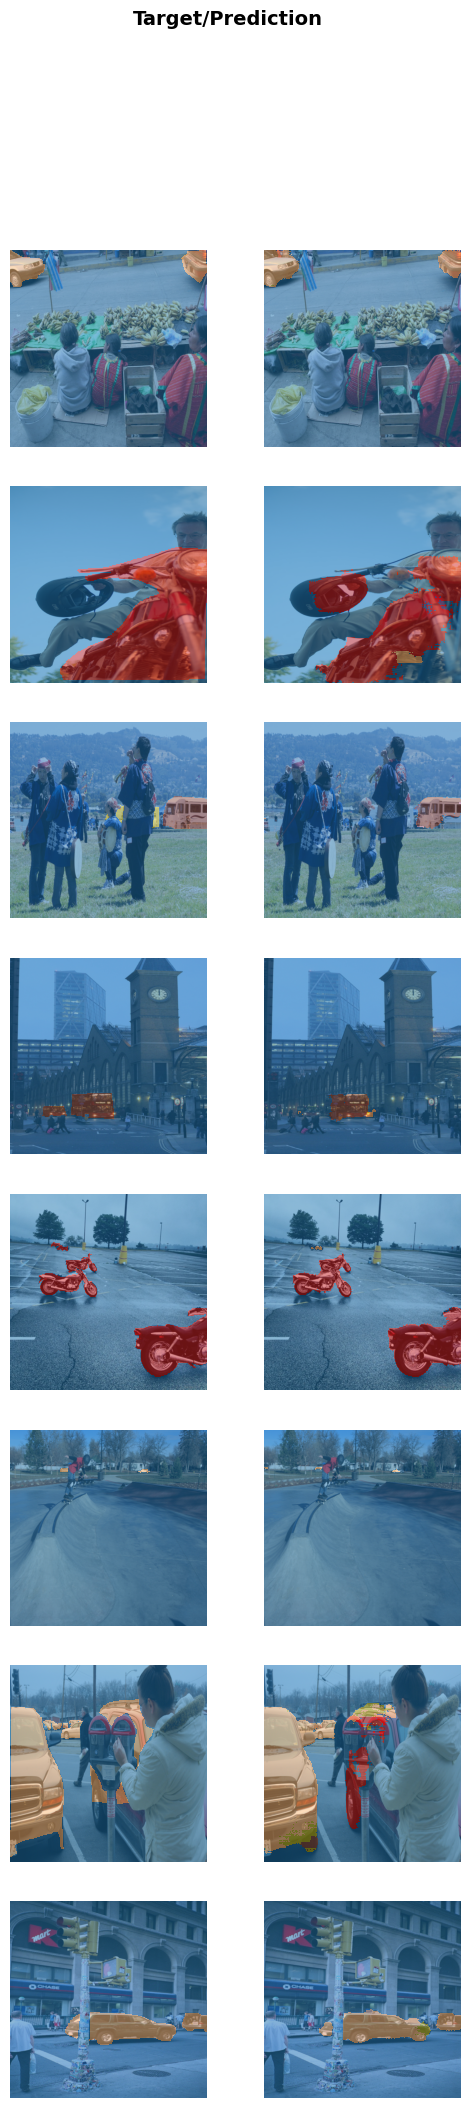

In [ ]:
# Mostramos algunas de las predicciones
learn_512_p.show_results()
learn_512_p.show_results()

Hemos visto que el hecho de entrenar la red con el encoder congelado entre cambios de tamaño de las imágenes realmente empeoraba los resultados. Vamos a realizar exactamente el mismo proceso, ahora sólo entrenando el modelo congelado al principio, cuando se inicializan los pesos de la red a los entrenados en IMAGENET. Además, no vamos a realizar ninguna época con las imágenes 512x512 ya que la mejora en los resultados no es significativa respecto al tiempo de ejecución.

In [ ]:
# Creamos el learner para unet preentrenado con resnet34 como backbone
learn_64_2 = unet_learner(dls_train_64, resnet34, normalize=True, pretrained=True,
                        loss_func=CrossEntropyLossFlat(axis=1), metrics=[DiceMulti, foreground_acc])

# Entrenamos la red congelada 3 épocas y la red completa 5
learn_64_2.fine_tune(epochs=5, freeze_epochs=3)

In [ ]:
# Cambiamos el nombre del learner (la referencia sigue siendo la misma)
learn_128_p_2 = learn_64_2

# Cambiamos el data loaders por el de imágenes de mayor tamaño
learn_128_p_2.dls = dls_train_128

# Entrenamos la red al completo durante tres épocas
learn_128_p_2.fine_tune(epochs=3, freeze_epochs=0)

In [ ]:
# Cambiamos el nombre del learner (la referencia sigue siendo la misma)
learn_256_p_2 = learn_128_p_2

# Cambiamos el data loaders por el de imágenes de mayor tamaño
learn_256_p_2.dls = dls_train_256

# Entrenamos la red al completo durante una sola época
learn_256_p_2.fine_tune(epochs=1, freeze_epochs=0)

Los resultados obtenidos en este caso son muy similares a los obtenidos entrenando algunas épocas con la red congelada. La variación en éstos probablemente se deba a factores estocásticos durante el entrenamiento.

Como hemos visto, el progressive resizing puede ser una herramienta muy interesante que en algunos casos, puede llevarnos a conseguir buenos resultados en tiempos significativamente menores que si entrenamos directamente con las imágenes a su tamaño final. En nuestro caso, esto no ha sido así, pues las métricas sobre validación para el primer modelo entrenado (solo imágenes 256x256) son bastante mejores en un tiempo de ejecución similar.

## Evaluación en test

Una vez hemos escogido el modelo que mejores resultados nos porporcionaen validación (learn_256), llega el momento de comprobar su rendimiento en los datos de test.

No hay demasiada información por parte de *fastai* para realizar esta tarea. En su página hemos encontrado un fragmento de código que nos permite calcular el valor de Dice (no funciona para foreground accuracy).

Nuestro conjunto de test inicial tenía unas 6000 imágenes, el problemas es que evaluar tantos datos llevaría una cantidad increíble de tiempo además de un elevado consumo de memora RAM para guardar las predicciones y los targets. Es por eso que tenemos que conformanos con un número mucho menor, 500 imágenes elegidas aleatoriamente del conjunto total con las que calcularemos el valor de Dice en test.

In [ ]:
# Código obtenido de https://docs.fast.ai/metrics.html para evaluar métricas en test

# For testing: a fake learner and a metric that isn't an average
@delegates()
class TstLearner(Learner):
    def __init__(self,dls=None,model=None,**kwargs): self.pred,self.xb,self.yb = None,None,None

# Go through a fake cycle with various batch sizes and computes the value of met
def compute_val(met, x1, x2):
    met.reset()
    vals = [0,6,15,20]
    learn = TstLearner()
    for i in range(3):
        learn.pred,learn.yb = x1[vals[i]:vals[i+1]],(x2[vals[i]:vals[i+1]],)
        met.accumulate(learn)
    return met.value

In [ ]:
# Número de imágenes del conjunto de test para la evaluación
N_TEST = 500

# Escogemos aleatoriamente N_TEST imágenes del conjunto de test
n_val_images_paths = random.sample(val_images_paths, N_TEST)

# Creamos el dataloader de test con las mismas tranformaciones que train
dls_test = learn_256.dls.test_dl(n_val_images_paths, with_labels=True)

In [ ]:
# Obtenemos predicciones y etiquetas de las imágenes
preds, targets = learn_256.get_preds(dl=dls_test)

In [ ]:
# Mostramos las métricas en test
print(f'Dice test: {compute_val(DiceMulti(), preds, targets)}')

Dice test: 0.865899350220075


Como podemos ver, obtenemos un valor para Dice en test alrededor de 0.86, lo que es aproximadamente un 0.08 más que lo que obteníamos en el conjunto de validación del mismo modelo. Esto significa una coincidencia bastante alta entre la segmentación real y la predicha. De haber podido evaluar el modelo con éste al completo, los resultados quizá hubiesen variado.

Es crucial destacar que, aunque una alta métrica de Dice es indicativa de una buena superposición entre segmentaciones reales y predichas, no constituye la única métrica determinante de la calidad general del modelo. Han quedado en el tintero otro tipo de pruebas con diferentes arquitecturas, un procesamiento de los datos más complejo, un ajuste más preciso de los hiperparámetros de los modelos, inicializaciones de parámetros más variadas, otro tipo de funciones de pérdida, la utilización de otro tipo de métricas o un diagnóstico e interpretación de los errores y virtudes de los modelos más exhaustivos.

## Referencias

* [COCO dataset](https://cocodataset.org/#home)
* [Métricas para segmentación en fastai](https://docs.fast.ai/metrics.html#segmentation)
* [Ejemplo de problema de segmentación con fastai](https://walkwithfastai.com/Segmentation)
* [Documentación de fastai respecto a segmentación](https://docs.fast.ai/tutorial.vision.html#segmentation---using-the-high-level-api)
* [Otro ejemplo de segmentación con fastai](https://towardsdatascience.com/image-segmentation-with-fastai-9f8883cc5b53)
* [Progressive resizing](https://docs.mosaicml.com/projects/composer/en/latest/method_cards/progressive_resizing.html)